### Generating Buy/Sell Signals using Mean Reversion Pairs Algorithm

Pairs mean reversion trading strategies rely on the ratio of two securities' prices regressing to its historical mean after large deviations. By longing or shorting the pair of stocks, an investor can make money as long as the spread between their prices narrows. For clarity, I will define longing the pair as taking a long position in the first stock and a short position in the second stock. Shorting the pair involves shorting the first stock and taking a long position in the second stock. Thus, it makes the most sense to use pairs of stocks whose returns are correlated. 

The first step in creating this strategy is to import all necessary libraries.

In [2]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import date
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg


In this example, I am using NVIDIA (NVDA) and Apple (AAPL), two very large cap tech stocks. I begin by downloading their data, using closing prices from the last year. 

In [18]:
ticker_1 = 'NVDA'
ticker_2 = 'AAPL'

data_1 = yf.download(ticker_1, period='1y', progress=False)
data_2 = yf.download(ticker_2, period='1y', progress=False)

data_1 = data_1['Close']
data_2 = data_2['Close']

Since these two companies exhibit many similarities in terms of industry and size, I will visualize their returns to see if there may be a correlation in their performance.

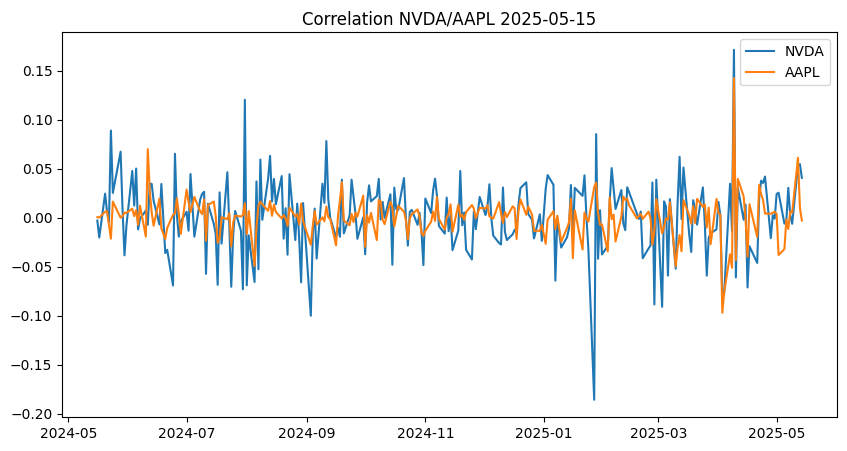

In [4]:
#Calculate returns
data_1_shifted = data_1.shift(1).dropna()
data_2_shifted = data_2.shift(1).dropna()

log_return_1 = np.log(data_1/data_1_shifted)
log_return_2 = np.log(data_2/data_2_shifted)

#Visualize Returns Correlation
plt.figure(figsize=(10, 5))
plt.plot(log_return_1, label=f'{ticker_1}')
plt.plot(log_return_2, label=f'{ticker_2}')
plt.title(f'Correlation {ticker_1}/{ticker_2} {date.today()}')
plt.legend()
plt.show()

As you can see, the two companies' returns seem to be related. However, to truly be certain that this relationship exists in the long run, I will test for cointegration using the Engle-Granger test. I begin by calculating residuals using an Ordinary Least Squares (OLS) regression. I then apply an augemented Dickey-Fuller (ADF) test to test for stationarity in the residuals, since stationarity implies cointegration. 

In [19]:
ind = sm.add_constant(data_1)
ols = sm.OLS(data_2, ind).fit()
residuals = ols.resid

adf_test = adfuller(residuals)
p_value = adf_test[1]
print(f'Cointegration p-value = {round(p_value, 4)}')

Cointegration p-value = 0.011


The resulting p-value is less than 0.05, suggesting sufficient enough evidence to reject the null hypothesis of no cointegration. Therefore, we have confirmed NVDA and AAPL are cointegrated and can apply the trading stratgey onto the pair. 

We are interested in the ratio of the stocks' prices, so we begin by rebasing their prices. Standardizing the prices allow us to calculate historical means and standard deviations. I implemented a 30 day rolling rebase in which every 30 days, the stocks' prices were rebased to 1, then calculated the ratio of the rebased prices.

In [6]:
rebase_df = pd.DataFrame(({ticker_1: data_1[ticker_1], 
                           ticker_2: data_2[ticker_2]}))
rebase_df.reset_index(drop=True, inplace=True)

for i in range(0, len(rebase_df), 30):
    rebase_value_1 = rebase_df.loc[i, ticker_1]
    rebase_df.loc[i:i+29, ticker_1] = (rebase_df.loc[i:i+29, ticker_1] / 
                                        rebase_value_1)
    rebase_value_2 = rebase_df.loc[i, ticker_2]
    rebase_df.loc[i:i+29, ticker_2] = (rebase_df.loc[i:i+29, ticker_2] / 
                                        rebase_value_2)

rebase_df['Ratio'] = rebase_df[ticker_1]/rebase_df[ticker_2]
print(rebase_df.head(5))

       NVDA      AAPL     Ratio
0  1.000000  1.000000  1.000000
1  0.997136  1.000633  0.996506
2  0.977269  1.000791  0.976497
3  1.001585  1.006958  0.994665
4  1.007989  1.013863  0.994207


To generate buy/sell signals, we calculate the mean and standard deviations of the data as well as establish the entry and exit thresholds for standard deviations from the mean. Through testing, I found the best entry threshold to be ±1.5σ and the best exit threshold to be ±0.67σ, which represent approximately 87% and 50% confidence intervals, respectively.

In [7]:
mean = rebase_df['Ratio'].mean()
std = rebase_df['Ratio'].std()
entry_threshold = 1.5 #87% CI
exit_threshold = 0.67 #50% CI

sell_signals = rebase_df[rebase_df['Ratio'] > mean + entry_threshold * std]
buy_signals = rebase_df[rebase_df['Ratio'] < mean - entry_threshold * std]
print(f'+{entry_threshold}sigma (sell):\n{sell_signals}')
print(f'-{entry_threshold}sigma (buy):\n{buy_signals}')

+1.5sigma (sell):
         NVDA      AAPL     Ratio
8    1.203646  1.001423  1.201935
9    1.213410  1.003004  1.209776
13   1.230445  1.024404  1.201132
14   1.293882  1.032416  1.253256
15   1.278643  1.025090  1.247348
16   1.277481  1.037793  1.230960
17   1.287013  1.017921  1.264354
20   1.369763  1.129243  1.212992
21   1.393753  1.120019  1.244401
22   1.384242  1.142051  1.212066
23   1.432856  1.129507  1.268568
24   1.382128  1.105208  1.250560
25   1.337635  1.093664  1.223076
27   1.332562  1.101992  1.209230
170  1.092468  0.897561  1.217151
171  1.140874  0.902358  1.264324
172  1.142037  0.901673  1.266576
173  1.106353  0.898125  1.231847
249  1.212615  0.996664  1.216674
-1.5sigma (buy):
         NVDA      AAPL     Ratio
42   0.955075  1.086697  0.878880
48   0.908855  1.032618  0.880147
50   0.903270  1.036179  0.871732
51   0.839647  1.038838  0.808256
53   0.884005  1.036749  0.852671
54   0.868302  1.043870  0.831810
55   0.813097  0.993590  0.818342
56   0.843856

We can visualize the movement of the ratio to see when these signals occured in the past

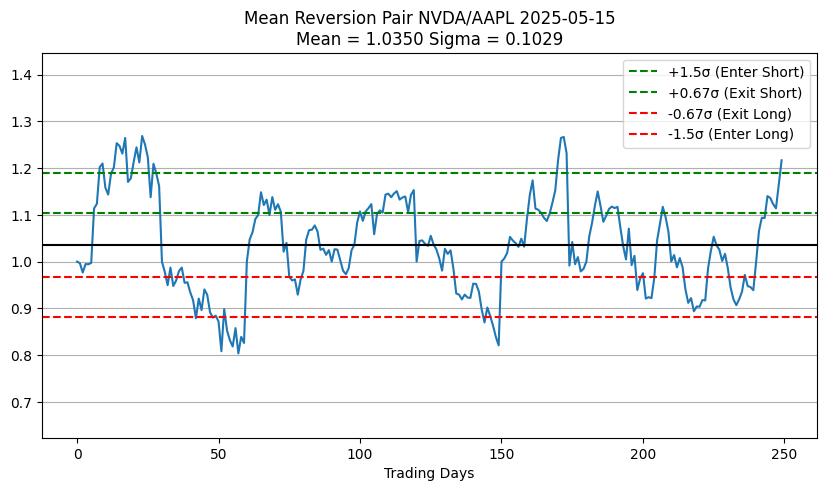

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(rebase_df['Ratio'])
plt.title(f'Mean Reversion Pair {ticker_1}/{ticker_2} {date.today()}\n' \
          f'Mean = {mean:.4f} Sigma = {std:.4f}')
plt.xlabel('Trading Days')
plt.grid(axis='y')
plt.ylim(mean-4*std, mean+4*std)
plt.axhline(mean + entry_threshold * std, color='green', 
            linestyle='dashed', label=f'+{entry_threshold}σ (Enter Short)')
plt.axhline(mean + exit_threshold * std, color='green', 
            linestyle='dashed', label=f'+{exit_threshold}σ (Exit Short)')
plt.axhline(mean - exit_threshold * std, color='red', 
            linestyle='dashed', label=f'-{exit_threshold}σ (Exit Long)')
plt.axhline(mean - entry_threshold * std, color='red', 
            linestyle='dashed', label=f'-{entry_threshold}σ (Enter Long)')
plt.axhline(mean, color='black')
plt.legend()
plt.show()

Now, in order to verify the profitability of this strategy, a simple backtesting strategy can allow us to see the cumulative profit and loss for this strategy over the last year as well as the overall return.

Final balance = 1068.04, Return = 6.80%


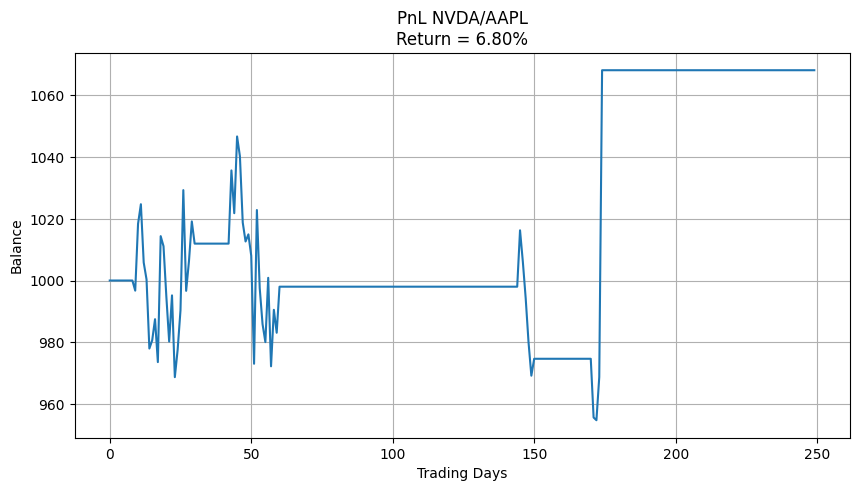

In [ ]:
backtest_df = pd.DataFrame({ticker_1: data_1[ticker_1], 
                            ticker_2: data_2[ticker_2]})
backtest_df.reset_index(inplace=True, drop=True)
backtest_df['Ratio'] = rebase_df['Ratio']

starting_balance = 10000
balance = starting_balance
position = 'neutral'

#dicts of all long and short positions with prices
stock_1 = {'long': [], 'short': []} 
stock_2 = {'long': [], 'short': []}

pnl = []

for i in range(len(backtest_df)):
    ratio = backtest_df.loc[i, 'Ratio']
    curr_price_1 = backtest_df.loc[i, ticker_1]
    curr_price_2 = backtest_df.loc[i, ticker_2]
    #define entry and exit points
    entry_short = mean + entry_threshold * std 
    entry_long = mean - entry_threshold * std
    exit_short = mean + exit_threshold * std
    exit_long = mean - exit_threshold * std
    #dollar neutral hedging
    allocation = balance / 2
    shares_1 = allocation / curr_price_1
    shares_2 = allocation / curr_price_2
    if position == 'neutral':
        if ratio < entry_long:
            position = 'long' #enter long position
            stock_1['long'].append((curr_price_1, shares_1))
            stock_2['short'].append((curr_price_2, shares_2))
        elif ratio > entry_short:
            position = 'short' #enter short position
            stock_1['short'].append((curr_price_1, shares_1))
            stock_2['long'].append((curr_price_2, shares_2))
    elif position == 'long':
        if ratio > exit_long: #exit long position
            entry_price_1, shares_1 = stock_1['long'].pop(0) #FIFO
            entry_price_2, shares_2 = stock_2['short'].pop(0)
            position = 'neutral'
            #calculate PnL gained from closing the position
            balance += (curr_price_1 - entry_price_1) * shares_1
            balance += (entry_price_2 - curr_price_2) * shares_2
    elif position == 'short':
        if ratio < exit_short: #exit short position
            entry_price_1, shares_1 = stock_1['short'].pop(0) #FIFO
            entry_price_2, shares_2 = stock_2['long'].pop(0)
            position = 'neutral'
            #calculate PnL gained from closing the position
            balance += (entry_price_1 - curr_price_1) * shares_1
            balance += (curr_price_2 - entry_price_2) * shares_2
    #calculate value of open positions
    total_long = 0
    total_short = 0
    for val in stock_1['long']:
        price, shares = val
        total_long += (curr_price_1 - price) * shares
    for val in stock_1['short']:
        price, shares = val
        total_short += (price - curr_price_1) * shares
    for val in stock_2['long']:
        price, shares = val
        total_long += (curr_price_2 - price) * shares
    for val in stock_2['short']:
        price, shares = val
        total_short += (price - curr_price_2) * shares
    #add PnL from transactions to value of current portfolio
    pnl.append(balance + total_long + total_short)
pnl = pd.Series(pnl)
final_balance = pnl.iloc[-1]
returns = ((final_balance - starting_balance)/starting_balance)*100

print(f'Final balance = {final_balance:.2f}, Return = {returns:.2f}%')  
plt.figure(figsize=(10, 5))
plt.plot(pnl)
plt.title(f'PnL {ticker_1}/{ticker_2}\n' \
          f'Return = {returns:.2f}%')
plt.xlabel('Trading Days')
plt.ylabel('Balance')
plt.grid(True)

plt.show()

We can see that this trading strategy worked historically. Now, we examine how it could be used on future data. To do that, we will simulate future price paths using Geometric Brownian Motion and see if the strategy converges over time using Monte Carlo simulations.

Geometric Brownian Motion is often used to model stock price paths as it incorporates randomness as well as exponential growth. The stochastic differential equation looks like this: 
$$
dS_t = \mu S_t \, dt + \sigma S_t \, dW_t
$$
where $S_t$ is the stock price at time t, $\mu$ is the drift or average return, $\sigma$ is the standard deviation of returns, and $W_t$ is a Wiener process which represents small increments of Brownian Motion (i.e. the randomness). 

Solving the equation requires the use of Ito's Lemma, and it results in the following: 
$$
S_t = S_0 \cdot \exp \left[ \left( \mu - \frac{1}{2} \sigma^2 \right) t + \sigma W_t \right]
$$

To incorporate this into the code, we write the function geomBrownianMotion as such, returning a numpy array of a price path

In [10]:
def geomBrownianMotion(s0, mu, sigma, t, n):
    dt = t/n
    dW = np.random.normal(0, np.sqrt(dt), n) #weiner process has mean 0 and st dev equal to square root of time step
    weiner_process = np.cumsum(dW)
    gbm = np.exp((mu - sigma**2 / 2) * dt + sigma * weiner_process)
    price_path = s0 * gbm
    return price_path

We can then find NVDA's current price, mean, and standard deviation of its returns to generate it's future price path. Note that in the GBM equation, $\mu$ is adjusted for variance, so we must also adjust ours. We have
$$
\mu_{daily} = \mu_{GBM} - \frac{\sigma^2}{2}
$$
So 
$$
\mu_{GBM} = \mu_{daily} + \frac{\sigma^2}{2}
$$

In [11]:
stock_1_s0 = data_1.iloc[0, 0]

sigma_1 = log_return_1.std(ddof=1) #pd series
sigma_1 = sigma_1.iloc[0] #float

daily_mu_1 = log_return_1.mean() #pd series
daily_mu_1 = daily_mu_1.iloc[0] #float
mu_1 = daily_mu_1 + (sigma_1**2)/2

We then define the time interval in years (t) as well as the time step (n), and can then simulate a possible price path for NVDA over the next year.

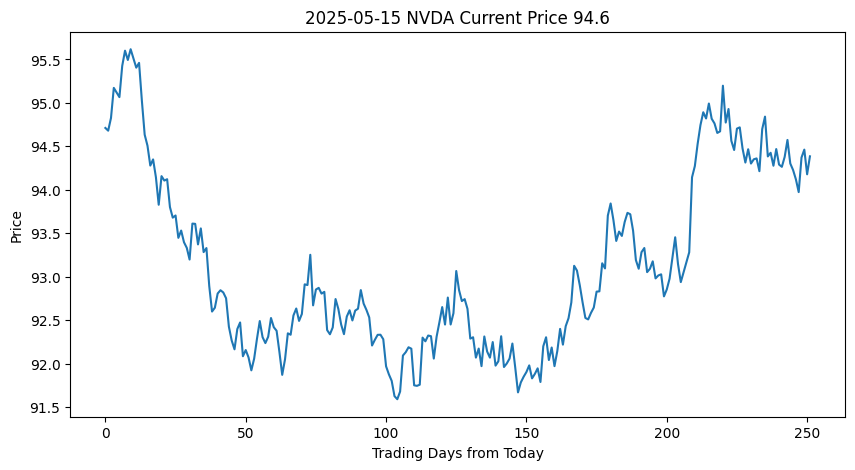

In [12]:
np.random.seed(42)

t = 1
n = 252 * t #252 trading days in a year
price_path_1 = geomBrownianMotion(stock_1_s0, mu_1, sigma_1, t, n)
plt.figure(figsize=(10, 5))
plt.title(f'{date.today()} {ticker_1} Current Price {round(stock_1_s0, 2)}')
plt.xlabel('Trading Days from Today')
plt.ylabel('Price')
plt.plot(price_path_1)
plt.show()

Now, we need to generate a random price path that is cointegrated with the simulated NVDA price path, assumign that the cointegrated relationship continues into the future. To do so, we attempt to establish a linear relationship between the two series such that the residuals are mean-reverting or stationary, thus satisfying 
$$
y_t = \alpha + \beta x_t + u_t
$$
where $\alpha$ and $\beta$ are constants, $x_t$ is NVDA's price path and $u_t$ is mean-reverting noise. 

We assume that $u_t$ follows the Autoregressive form 
$$
u_t = \phi u_{t-1} + \epsilon_t
$$
This Autoregressive model with a lag of 1 is known as an AR(1) model and contains an autoregressive coefficient satisfying $|\phi| < 1$ to be mean-reverting as well as white noise, $\epsilon_t \sim N(0, \sigma_u^2)$.

We can find $\alpha$ and $\beta$ by taking the constant and coefficient of the OLS model fitted to the two stocks' historical prices.

In [13]:
alpha = ols.params.iloc[0]
beta = ols.params.iloc[1]
print(f'alpha = {alpha}, beta = {beta}')

alpha = 121.22983410525723, beta = 0.8159424110683805


We can also estime $\phi$ and $\sigma_u$ by using the residuals from the OLS model assuming it follows an Autoregressive process.

In [14]:
auto_reg = AutoReg(residuals.reset_index(drop=True), lags=1).fit()

phi = auto_reg.params.iloc[1]  # lag-1 coefficient
sigma_u = np.std(auto_reg.resid)

print(f'phi = {phi}, sigma_u = {sigma_u}')

phi = 0.9337987775602391, sigma_u = 4.426780625621116


Now that we have values for $\alpha$, $\beta$, $\phi$, and $\sigma_u$, we can create the linear relationship.

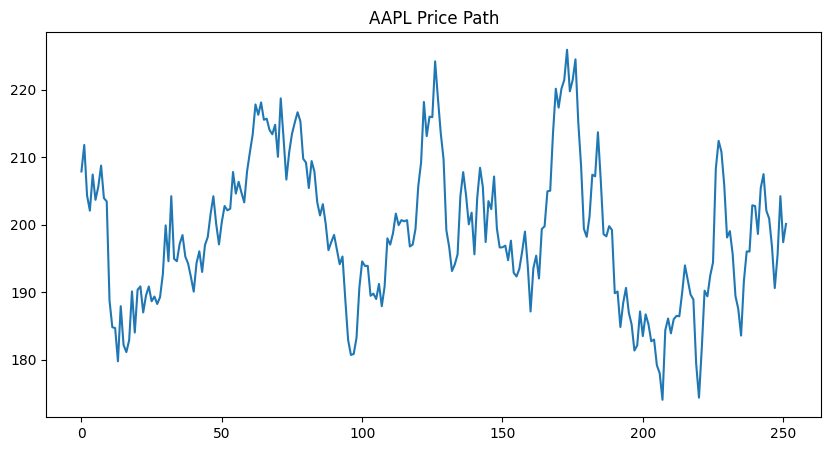

In [15]:
def createCointegratedSeries(alpha, beta, phi, sigma_u, price_path, n):
    #create mean-reverting residuals
    u_t = np.zeros(n)
    epsilon = np.random.normal(0, sigma_u, n) #white noise
    for t in range(n):
        u_t[t] = phi*u_t[t-1] + epsilon[t]

    #create the cointegrated series
    coint_path = alpha + beta * price_path + u_t
    return coint_path

price_path_2 = createCointegratedSeries(alpha, beta, phi, sigma_u, price_path_1, n)
plt.figure(figsize=(10, 5))
plt.title(f'{ticker_2} Price Path')
plt.plot(price_path_2)
plt.show()

And to double check that the price movements are cointegrated:

In [16]:
ind = sm.add_constant(price_path_1)
ols = sm.OLS(price_path_2, ind).fit()
residuals = ols.resid

adf_test = adfuller(residuals)
p_value = adf_test[1]
print(f'Cointegration p-value = {round(p_value, 4)}')

Cointegration p-value = 0.0047


Now that we can sucessfully generate future price paths, we employ a Monte Carlo simulation to test our strategy thousands of times to measure its performance.

In each iteration of the simulation function we will generate a price path for each stock, then follow the same methods as before by rebasing the data, finding price ratio, and creating our entry and exit levels.

Average return over 1000 simulations: 16.76%


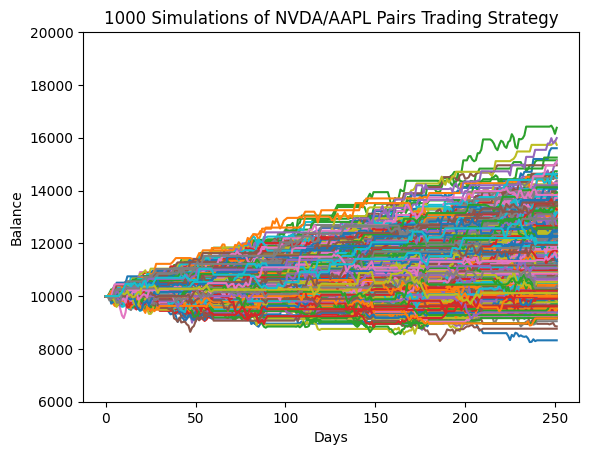

In [ ]:
np.random.seed(42)

num_sims = 1000
def simulateStrategy(num_sims):
    all_returns = []
    for _ in range(num_sims):
        #Simulate stock price paths
        stock_1_price_path = geomBrownianMotion(stock_1_s0, mu_1, sigma_1, t, n)
        stock_2_price_path = createCointegratedSeries(alpha, beta, phi, sigma_u, 
                                                stock_1_price_path, n)
        future_data = pd.DataFrame({ticker_1: stock_1_price_path,
                                    ticker_2: stock_2_price_path})
        # rebase the data
        rebase_df = future_data.copy()
        for i in range(0, len(rebase_df), 30):
            rebase_value_1 = rebase_df.loc[i, ticker_1]
            rebase_df.loc[i:i+29, ticker_1] = (rebase_df.loc[i:i+29, ticker_1] / 
                                                rebase_value_1)
            rebase_value_2 = rebase_df.loc[i, ticker_2]
            rebase_df.loc[i:i+29, ticker_2] = (rebase_df.loc[i:i+29, ticker_2] / 
                                                rebase_value_2)
        # calculate the ratio, mean, std, entry, and exit
        rebase_df['Ratio'] = rebase_df[ticker_1]/rebase_df[ticker_2]
        mean = rebase_df['Ratio'].mean()
        std = rebase_df['Ratio'].std()
        entry_threshold = 1.15 #75% CI
        exit_threshold = 0.67 #50% CI

        #calculating PnL
        future_data['Ratio'] = rebase_df['Ratio']

        starting_balance = 10000
        balance = starting_balance
        position = 'neutral'

        stock_1 = {'long': [], 'short': []} #dict of all long and short positions with prices
        stock_2 = {'long': [], 'short': []}

        pnl = []

        for i in range(len(future_data)):
            ratio = future_data.loc[i, 'Ratio']
            curr_price_1 = future_data.loc[i, ticker_1]
            curr_price_2 = future_data.loc[i, ticker_2]
            entry_short = mean + entry_threshold * std
            entry_long = mean - entry_threshold * std
            exit_short = mean + exit_threshold * std
            exit_long = mean - exit_threshold * std
            allocation = balance / 2
            shares_1 = allocation / curr_price_1
            shares_2 = allocation / curr_price_2
            if position == 'neutral':
                if ratio < entry_long:
                    position = 'long'
                    stock_1['long'].append((curr_price_1, shares_1))
                    stock_2['short'].append((curr_price_2, shares_2))
                elif ratio > entry_short:
                    position = 'short'
                    stock_1['short'].append((curr_price_1, shares_1))
                    stock_2['long'].append((curr_price_2, shares_2))
            elif position == 'long':
                if ratio > exit_long:
                    entry_price_1, shares_1 = stock_1['long'].pop(0) #FIFO
                    entry_price_2, shares_2 = stock_2['short'].pop(0)
                    position = 'neutral'
                    balance += (curr_price_1 - entry_price_1) * shares_1
                    balance += (entry_price_2 - curr_price_2) * shares_2
            elif position == 'short':
                if ratio < exit_short:
                    entry_price_1, shares_1 = stock_1['short'].pop(0) #FIFO
                    entry_price_2, shares_2 = stock_2['long'].pop(0)
                    position = 'neutral'
                    balance += (entry_price_1 - curr_price_1) * shares_1
                    balance += (curr_price_2 - entry_price_2) * shares_2
            total_long = 0
            total_short = 0
            for val in stock_1['long']:
                price, shares = val
                total_long += (curr_price_1 - price) * shares
            for val in stock_1['short']:
                price, shares = val
                total_short += (price - curr_price_1) * shares
            for val in stock_2['long']:
                price, shares = val
                total_long += (curr_price_2 - price) * shares
            for val in stock_2['short']:
                price, shares = val
                total_short += (price - curr_price_2) * shares
            pnl.append(balance + total_long + total_short)
        pnl = pd.Series(pnl)
        final_balance = pnl.iloc[-1]
        returns = ((final_balance - starting_balance)/starting_balance)*100
        all_returns.append(returns)
        plt.plot(pnl)
    return (sum(all_returns)/len(all_returns)) #average returns

avg_return = simulateStrategy(1000)
print(f'Average return over {num_sims} simulations: {round(avg_return, 2)}%')
plt.title(f'{num_sims} Simulations of {ticker_1}/{ticker_2} Pairs Trading Strategy')
plt.xlabel('Days')
plt.ylabel('Balance')
plt.ylim(6000, 20000)
plt.axhline(y=1000, color='black')
plt.show()


As can be seen, this strategy's end balance seem to converge towards a number greater than 10000. With an expected return of 16.76%, it can be seen that this is a viable trading strategy.